In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/wesad-main')

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
!pip install autokeras
import autokeras as ak

print("AutoKeras version:", ak.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.0 MB/s eta 0:00:00
AutoKeras version: 2.0.0


In [ ]:
from ae_feature_extractor import autoencoder
ae = autoencoder ()

## Chest and Wrist Physio modalities classification

In [ ]:
# Define the Binarized Neural Network
class BNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(BNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(torch.sign(self.fc1(x)))  # Binarized with ReLU
        x = torch.relu(torch.sign(self.fc2(x)))
        x = self.fc3(x)
        return x

# Initialize lists to store results
scores_all = []
cms = []

# Loop through each subject for LOSO validation
for sid in ae.ids:
    print(f"Processing Subject {sid}...")

    # Load training and testing features
    feat = np.array(pd.read_pickle(f"/content/drive/MyDrive/Colab Notebooks/wesad-main/features/train/feat_loso{sid}.pkl"))
    feat_test = np.array(pd.read_pickle(f"/content/drive/MyDrive/Colab Notebooks/wesad-main/features/test/feat_loso{sid}.pkl"))

    # Separate features and labels
    y = feat[:, -1].astype(int)
    x = feat[:, :-1]
    y_test = feat_test[:, -1].astype(int)
    x_test = feat_test[:, :-1]

    # Apply SMOTE to balance the classes
    smote = SMOTE(random_state=42)
    x, y = smote.fit_resample(x, y)
    print("Resampled training label distribution:", Counter(y))

    # Standardize features using the same scaler
    scaler = StandardScaler()
    x = scaler.fit_transform(x)  # Fit on training data
    x_test = scaler.transform(x_test)  # Transform test data using the same scaler

    # Adjust labels to start from 0 if necessary
    if np.min(y) != 0:
        y -= np.min(y)
    if np.min(y_test) != 0:
        y_test -= np.min(y_test)

    # Convert data to PyTorch tensors
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create DataLoader for training data
    train_dataset = TensorDataset(x_tensor, y_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Define the BNN model
    input_dim = x.shape[1]
    num_classes = len(np.unique(y))
    print(f"Number of classes: {num_classes}")
    model = BNN(input_dim, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the BNN
    model.train()
    for epoch in range(10):
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(x_test_tensor)
        y_pred = torch.argmax(y_pred_tensor, axis=1).numpy()

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    cm = confusion_matrix(y_test, y_pred)

    # Print results for this subject
    print(f"Subject {sid} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

    # Store results
    scores_all.append([sid, acc, precision, recall, f1])
    cms.append(cm)

Processing Subject 2...
Resampled training label distribution: Counter({np.int64(1): 16467, np.int64(2): 16467, np.int64(3): 16467})
Number of classes: 3
Epoch 1, Loss: 698.5556
Epoch 2, Loss: 614.4358
Epoch 3, Loss: 602.7365
Epoch 4, Loss: 598.5443
Epoch 5, Loss: 596.4537
Epoch 6, Loss: 595.3548
Epoch 7, Loss: 594.9015
Epoch 8, Loss: 594.3546
Epoch 9, Loss: 593.9079
Epoch 10, Loss: 593.8517
Subject 2 - Accuracy: 0.5926, F1 Score: 0.5982
Processing Subject 3...
Resampled training label distribution: Counter({np.int64(1): 16471, np.int64(2): 16471, np.int64(3): 16471})
Number of classes: 3
Epoch 1, Loss: 646.5963
Epoch 2, Loss: 574.9483
Epoch 3, Loss: 567.4069
Epoch 4, Loss: 563.9591
Epoch 5, Loss: 563.1263
Epoch 6, Loss: 562.7082
Epoch 7, Loss: 562.7342
Epoch 8, Loss: 562.7317
Epoch 9, Loss: 561.9891
Epoch 10, Loss: 562.1164
Subject 3 - Accuracy: 0.6713, F1 Score: 0.6830
Processing Subject 4...
Resampled training label distribution: Counter({np.int64(1): 16453, np.int64(2): 16453, np.i

In [ ]:
np.array(scores_all)[:,1].mean() #accuracy

np.float64(0.674541490903869)

In [ ]:
np.array(scores_all)[:,1].std()

np.float64(0.08073507865203605)

In [ ]:
np.array(scores_all)[:,2].mean() #precision

np.float64(0.7033222556610323)

In [ ]:
np.array(scores_all)[:,2].std()

np.float64(0.0677337705182365)

In [ ]:
np.array(scores_all)[:,3].mean() #recall

np.float64(0.674541490903869)

In [ ]:
np.array(scores_all)[:,3].std()

np.float64(0.08073507865203605)

In [ ]:
np.array(scores_all)[:,4].mean() #f1-score

np.float64(0.679450464233035)

In [ ]:
np.array(scores_all)[:,4].std()

np.float64(0.07518164824610742)

### Confusion Matrices per subject and for all subjects combined

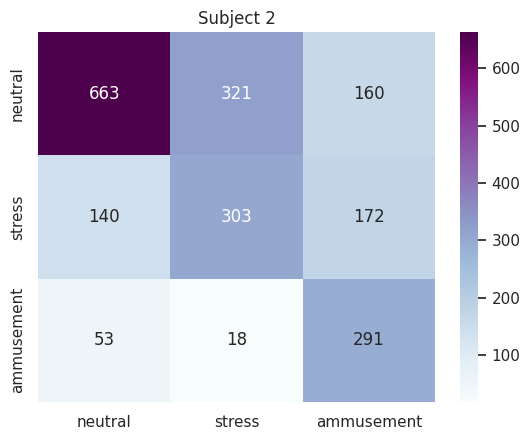

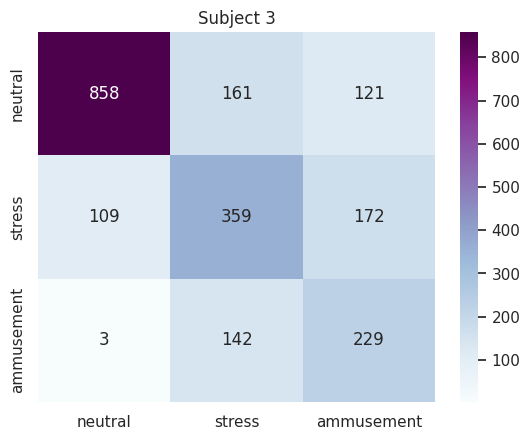

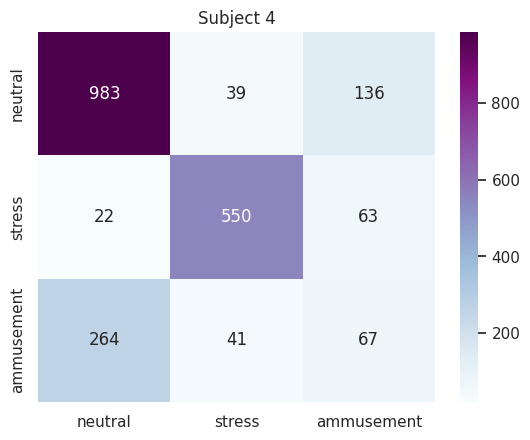

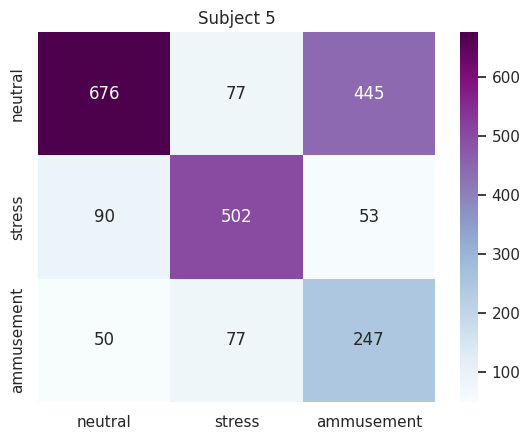

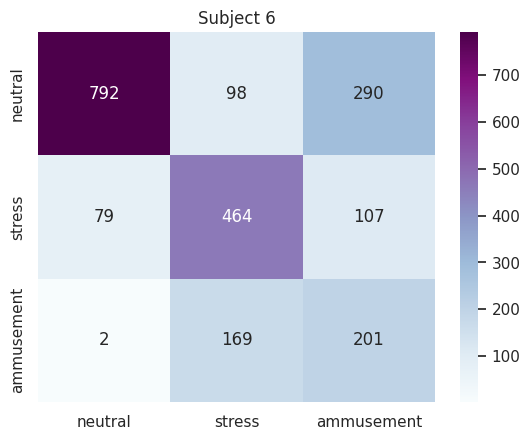

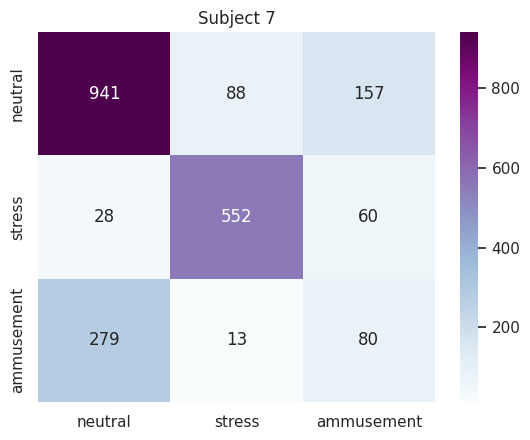

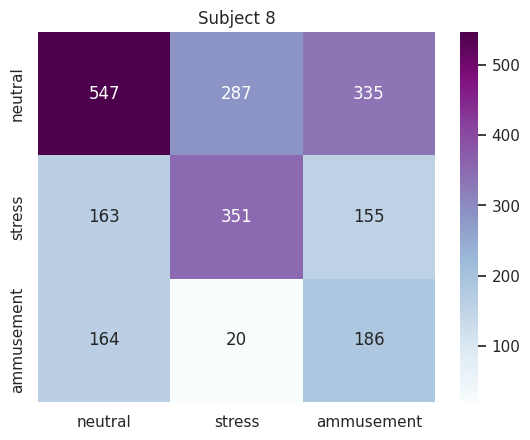

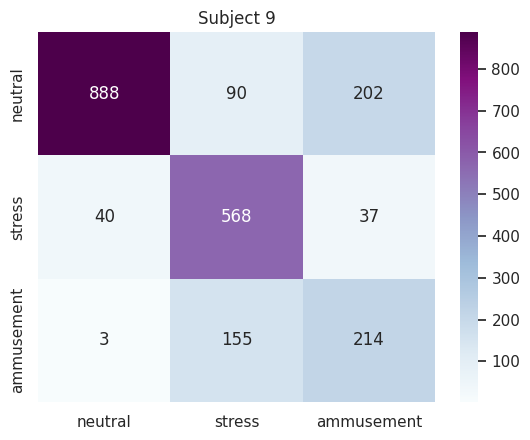

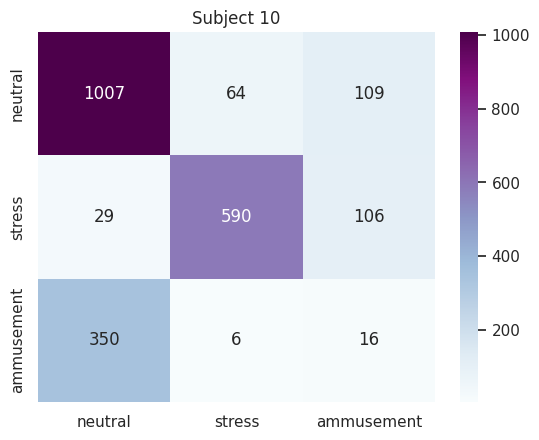

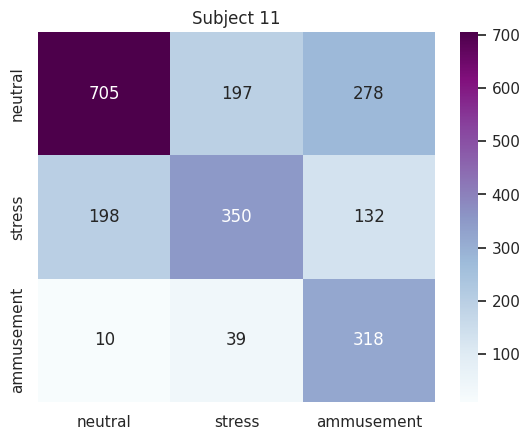

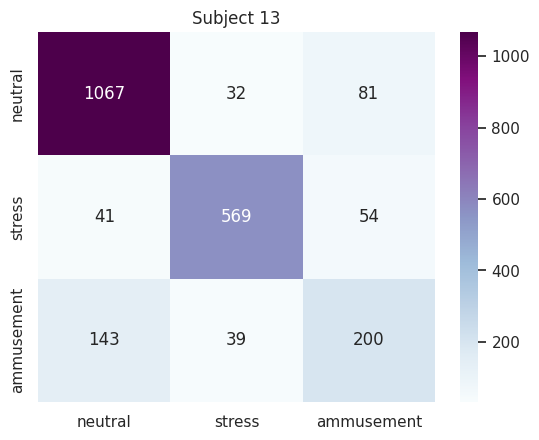

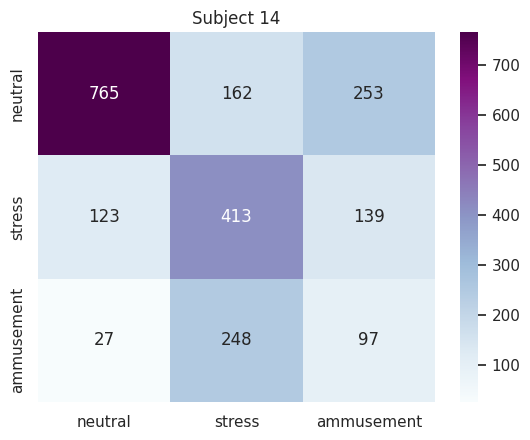

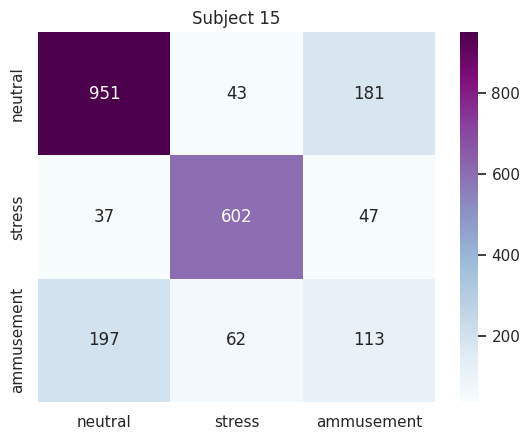

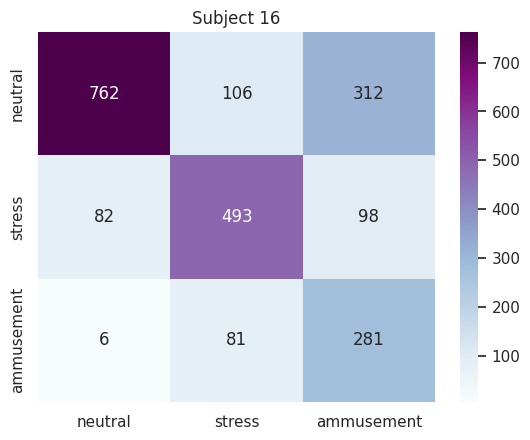

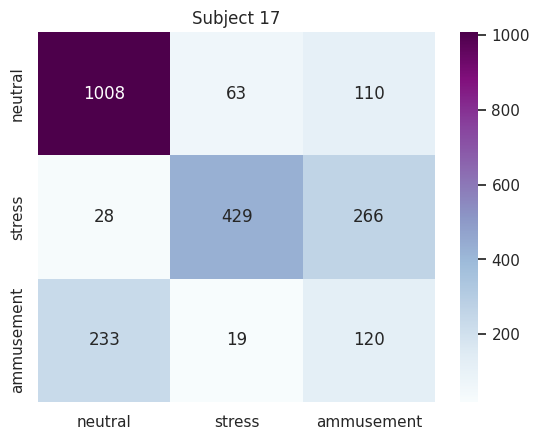

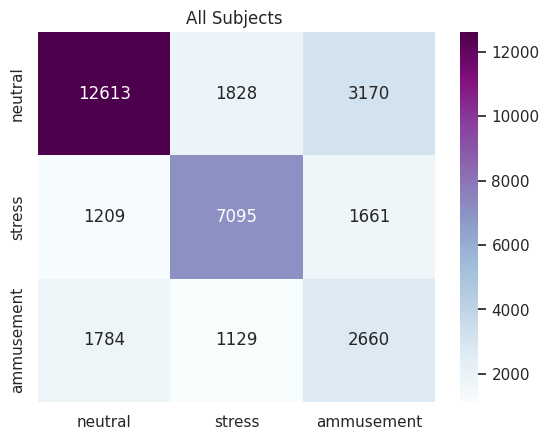

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
cm_all = np.zeros((3,3))
class_names = ['neutral', 'stress', 'ammusement']
for sid, cm in list(zip(np.array(scores_all)[:,0], cms)):
    #print("Subject ", int(sid))
    cm_all += cm
    df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
    sn.set(font_scale=1) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu",  fmt='d') # font size
    plt.title("Subject " + str(int(sid)))
    plt.show()

df_cm = pd.DataFrame(cm_all.astype(int), columns=class_names, index=class_names)
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu",  fmt='d') # font size
plt.title("All Subjects ")
plt.show()


## Chest only physio modalities classification

In [ ]:
# use chest only features for classification
scores_c = []
cms = []

for sid in ae.ids:
    feat = np.array(pd.read_pickle ("/content/drive/MyDrive/Colab Notebooks/wesad-main/features/train/feat_loso" + str(sid) + ".pkl"))
    feat_test = np.array(pd.read_pickle ("/content/drive/MyDrive/Colab Notebooks/wesad-main/features/test/feat_loso" + str(sid) + ".pkl"))

    y = feat[:,-1]
    x = feat[:,:80]
    x = StandardScaler().fit_transform(x)

    y_test = feat_test[:,-1]
    x_test = feat_test[:,:80]
    x_test = StandardScaler().fit_transform(x_test)

    # Apply SMOTE to balance the classes
    smote = SMOTE(random_state=42)
    x, y = smote.fit_resample(x, y)
    print("Resampled training label distribution:", Counter(y))

    # Adjust labels to start from 0 if necessary
    if np.min(y) != 0:
        y -= np.min(y)
    if np.min(y_test) != 0:
        y_test -= np.min(y_test)

    # Convert data to PyTorch tensors
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create DataLoader for training data
    train_dataset = TensorDataset(x_tensor, y_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Define the BNN model
    input_dim = x.shape[1]
    num_classes = len(np.unique(y))
    print(f"Number of classes: {num_classes}")
    model = BNN(input_dim, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the BNN
    model.train()
    for epoch in range(10):
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(x_test_tensor)
        y_pred = torch.argmax(y_pred_tensor, axis=1).numpy()

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    cm = confusion_matrix(y_test, y_pred)

    # Print results for this subject
    print(f"Subject {sid} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

    scores_c.append([sid, acc, precision, recall, f1])
    cms.append(cm)

Resampled training label distribution: Counter({np.float64(1.0): 16467, np.float64(2.0): 16467, np.float64(3.0): 16467})
Number of classes: 3
Epoch 1, Loss: 676.5068
Epoch 2, Loss: 600.1858
Epoch 3, Loss: 592.1461
Epoch 4, Loss: 589.4037
Epoch 5, Loss: 588.3784
Epoch 6, Loss: 587.9508
Epoch 7, Loss: 587.6241
Epoch 8, Loss: 587.5501
Epoch 9, Loss: 587.2493
Epoch 10, Loss: 587.0216
Subject 2 - Accuracy: 0.4592, F1 Score: 0.4677
Resampled training label distribution: Counter({np.float64(1.0): 16471, np.float64(2.0): 16471, np.float64(3.0): 16471})
Number of classes: 3
Epoch 1, Loss: 673.0402
Epoch 2, Loss: 595.9014
Epoch 3, Loss: 588.6081
Epoch 4, Loss: 586.9748
Epoch 5, Loss: 585.1491
Epoch 6, Loss: 585.1216
Epoch 7, Loss: 584.6462
Epoch 8, Loss: 584.8884
Epoch 9, Loss: 584.4462
Epoch 10, Loss: 584.2985
Subject 3 - Accuracy: 0.6565, F1 Score: 0.6699
Resampled training label distribution: Counter({np.float64(1.0): 16453, np.float64(2.0): 16453, np.float64(3.0): 16453})
Number of classes: 

In [ ]:
np.array(scores_c)[:,1].mean() #accuracy

np.float64(0.681949994544127)

In [ ]:
np.array(scores_c)[:,1].std()

np.float64(0.11421657284619109)

In [ ]:
np.array(scores_c)[:,2].mean() #precision

np.float64(0.7159621890837532)

In [ ]:
np.array(scores_c)[:,2].std()

np.float64(0.09345046996737437)

In [ ]:
np.array(scores_c)[:,3].mean() #recall

np.float64(0.681949994544127)

In [ ]:
np.array(scores_c)[:,3].std()

np.float64(0.11421657284619109)

In [ ]:
np.array(scores_c)[:,4].mean() #f1-score

np.float64(0.6884493023416095)

In [ ]:
np.array(scores_c)[:,4].std()

np.float64(0.1101957948798944)

### Confusion Matrices per subject and for all subjects combined

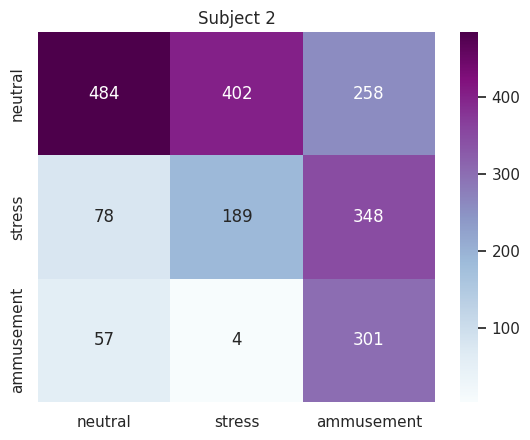

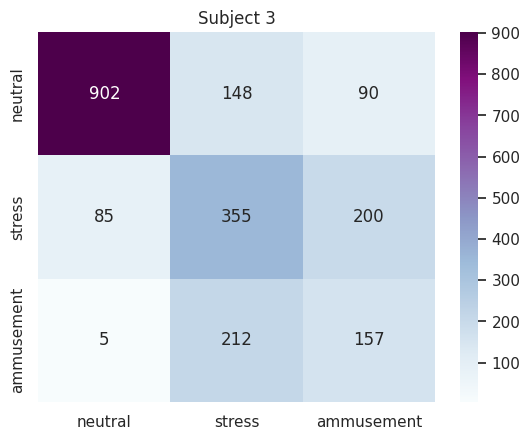

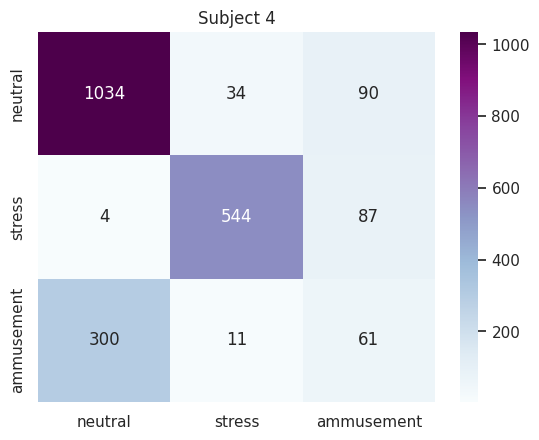

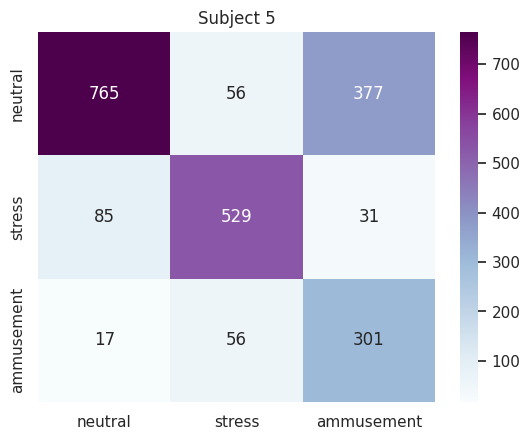

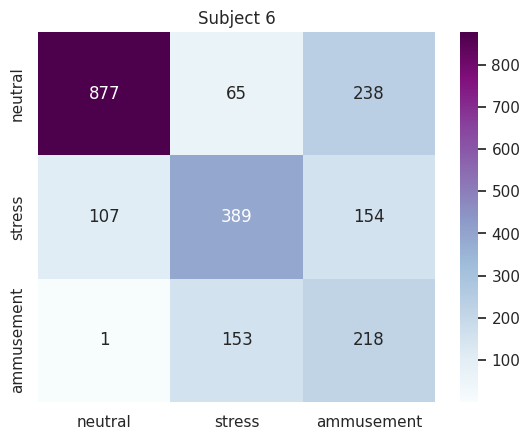

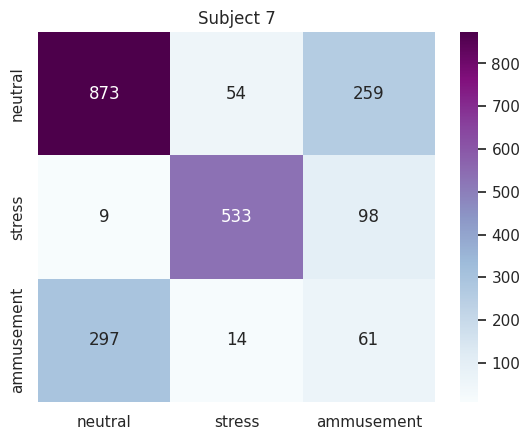

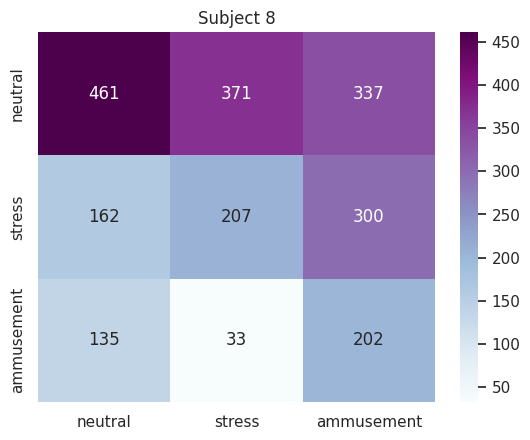

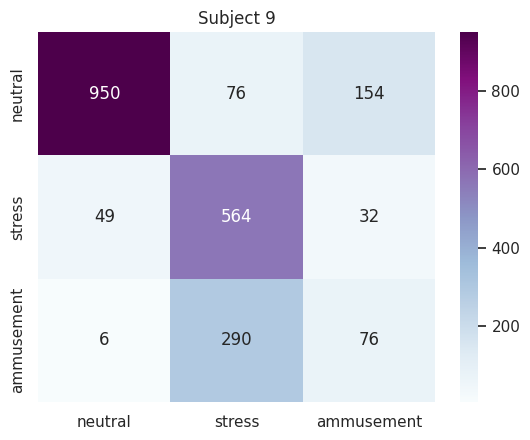

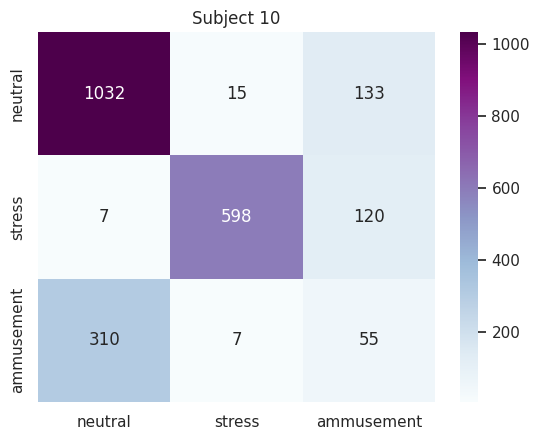

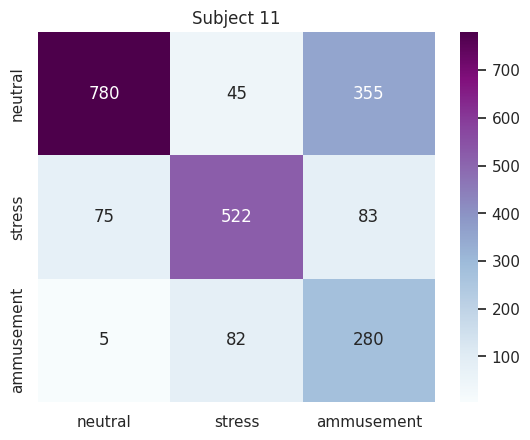

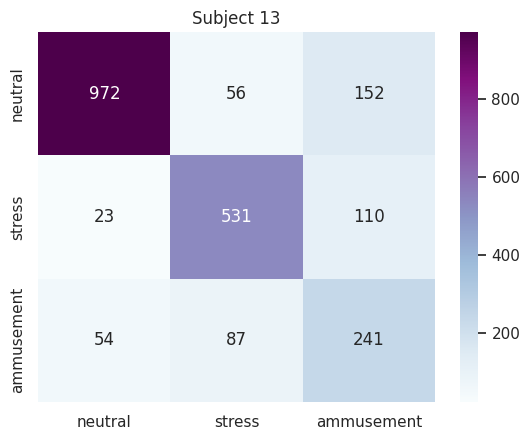

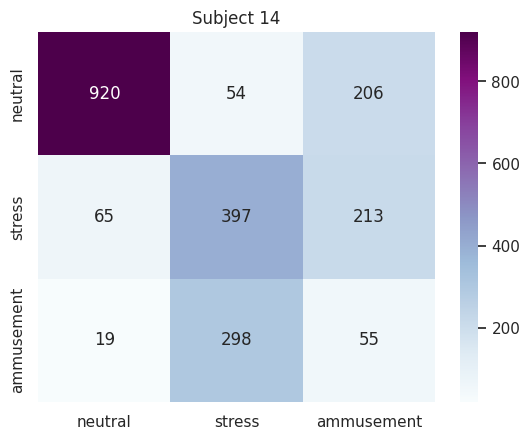

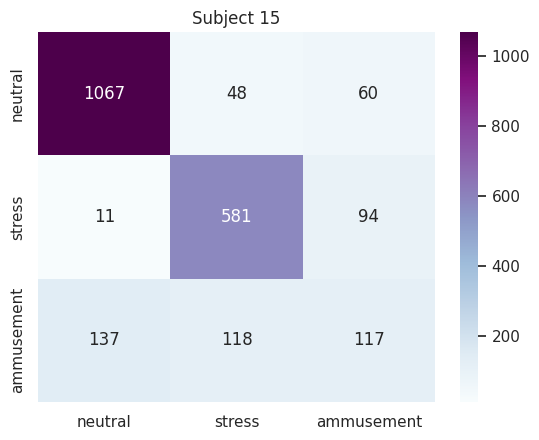

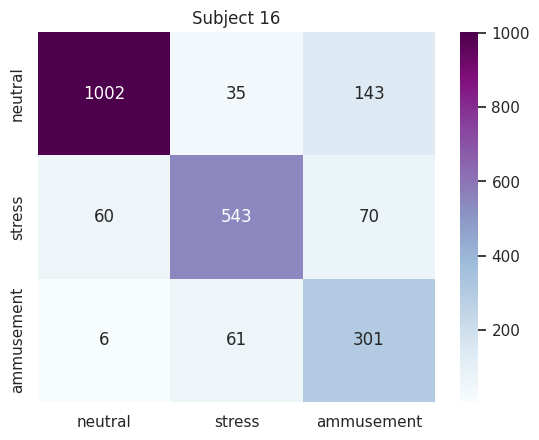

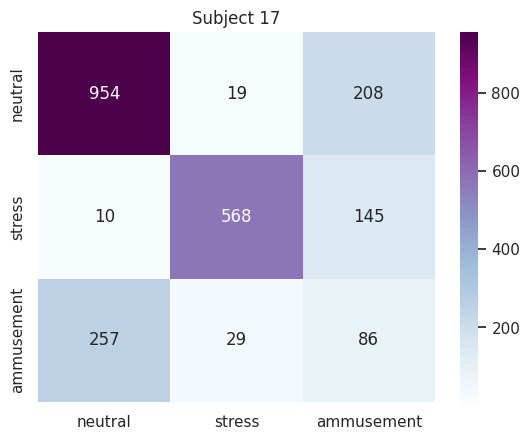

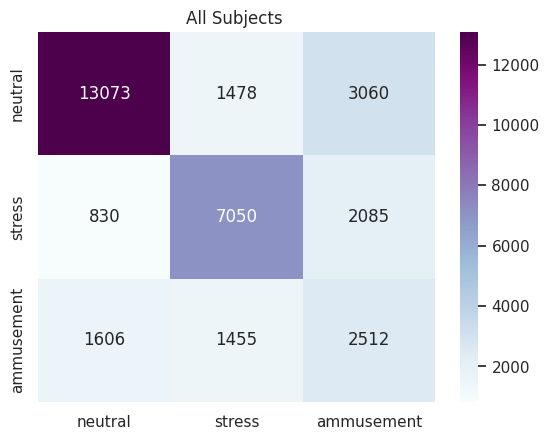

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
cm_all = np.zeros((3,3))
class_names = ['neutral', 'stress', 'ammusement']
for sid, cm in list(zip(np.array(scores_c)[:,0], cms)):
    #print("Subject ", int(sid))
    cm_all += cm
    df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
    sn.set(font_scale=1) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu",  fmt='d') # font size
    plt.title("Subject " + str(int(sid)))
    plt.show()

df_cm = pd.DataFrame(cm_all.astype(int), columns=class_names, index=class_names)
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu",  fmt='d') # font size
plt.title("All Subjects ")
plt.show()

## Wrist only physio modalities classification

In [ ]:
# Initialize lists to store results
scores_w = []
cms = []

# Loop through each subject for LOSO validation
for sid in ae.ids:
    # Load training and testing features
    feat = np.array(pd.read_pickle(f"/content/drive/MyDrive/Colab Notebooks/wesad-main/features/train/feat_loso{sid}.pkl"))
    feat_test = np.array(pd.read_pickle(f"/content/drive/MyDrive/Colab Notebooks/wesad-main/features/test/feat_loso{sid}.pkl"))

    # Extract wrist-only features
    y = feat[:, -1]
    x = feat[:, 80:-1]
    y_test = feat_test[:, -1]
    x_test = feat_test[:, 80:-1]

    # Apply SMOTE to balance the classes
    smote = SMOTE(random_state=42)
    x, y = smote.fit_resample(x, y)
    print("Resampled training label distribution:", Counter(y))

    # Standardize features using the same scaler
    scaler = StandardScaler()
    x = scaler.fit_transform(x)  # Fit on training data
    x_test = scaler.transform(x_test)  # Transform test data using the same scaler

    # Adjust labels to start from 0 if necessary
    if np.min(y) != 0:
        y -= np.min(y)
    if np.min(y_test) != 0:
        y_test -= np.min(y_test)

    # Convert data to PyTorch tensors
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create DataLoader for training data
    train_dataset = TensorDataset(x_tensor, y_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Define the BNN model
    input_dim = x.shape[1]
    num_classes = len(np.unique(y))
    print(f"Number of classes: {num_classes}")
    model = BNN(input_dim, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the BNN
    model.train()
    for epoch in range(10):
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(x_test_tensor)
        y_pred = torch.argmax(y_pred_tensor, axis=1).numpy()

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    cm = confusion_matrix(y_test, y_pred)

    # Print results for this subject
    print(f"Subject {sid} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

    # Store results
    scores_w.append([sid, acc, precision, recall, f1])
    cms.append(cm)

Resampled training label distribution: Counter({np.float64(1.0): 16467, np.float64(2.0): 16467, np.float64(3.0): 16467})
Number of classes: 3
Epoch 1, Loss: 675.8047
Epoch 2, Loss: 613.8042
Epoch 3, Loss: 607.2585
Epoch 4, Loss: 605.3446
Epoch 5, Loss: 604.4728
Epoch 6, Loss: 604.0213
Epoch 7, Loss: 603.6693
Epoch 8, Loss: 603.5815
Epoch 9, Loss: 603.2177
Epoch 10, Loss: 603.4752
Subject 2 - Accuracy: 0.7487, F1 Score: 0.7527
Resampled training label distribution: Counter({np.float64(1.0): 16471, np.float64(2.0): 16471, np.float64(3.0): 16471})
Number of classes: 3
Epoch 1, Loss: 698.4599
Epoch 2, Loss: 623.3784
Epoch 3, Loss: 612.4205
Epoch 4, Loss: 607.6994
Epoch 5, Loss: 606.1004
Epoch 6, Loss: 605.4660
Epoch 7, Loss: 604.3529
Epoch 8, Loss: 604.1533
Epoch 9, Loss: 604.0259
Epoch 10, Loss: 603.4667
Subject 3 - Accuracy: 0.6096, F1 Score: 0.6222
Resampled training label distribution: Counter({np.float64(1.0): 16453, np.float64(2.0): 16453, np.float64(3.0): 16453})
Number of classes: 

In [ ]:
np.array(scores_w)[:,1].mean() #accuracy

np.float64(0.6382988108802555)

In [ ]:
np.array(scores_w)[:,1].std()

np.float64(0.11282354485063584)

In [ ]:
np.array(scores_w)[:,2].mean() #precision

np.float64(0.6752517213469563)

In [ ]:
np.array(scores_w)[:,2].std()

np.float64(0.09617355036060236)

In [ ]:
np.array(scores_w)[:,3].mean() #recall

np.float64(0.6382988108802555)

In [ ]:
np.array(scores_w)[:,3].std()

np.float64(0.11282354485063584)

In [ ]:
np.array(scores_w)[:,4].mean() #f1-score

np.float64(0.6401901727654035)

In [ ]:
np.array(scores_w)[:,4].std()

np.float64(0.10685713335656437)

### Confusion Matrices per subject and for all subjects combined

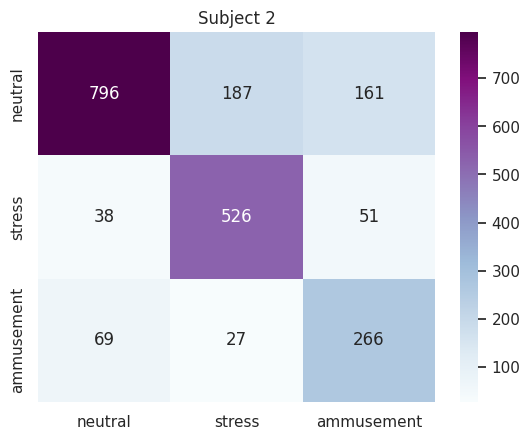

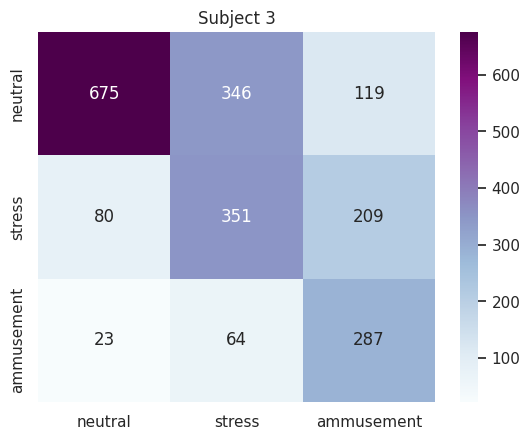

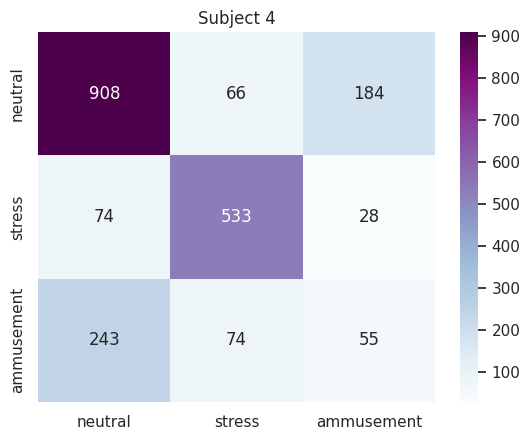

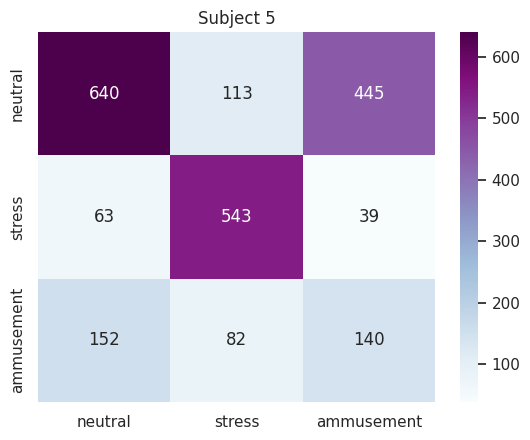

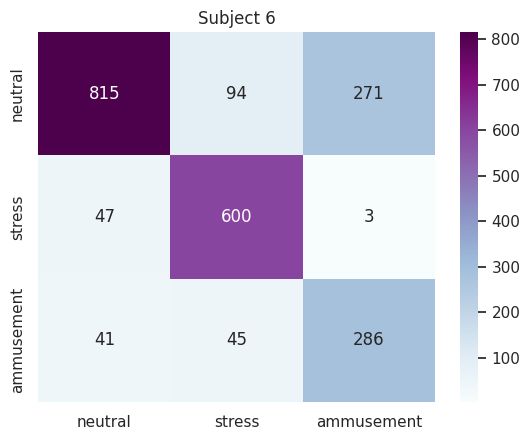

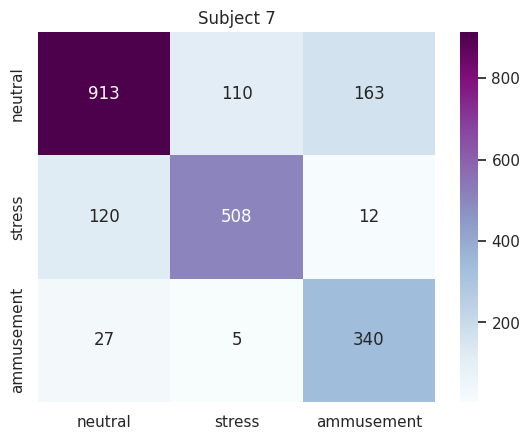

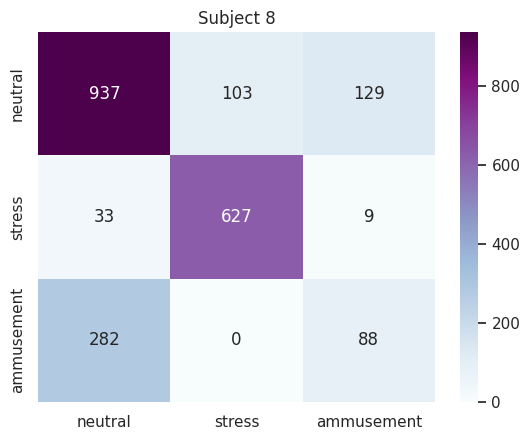

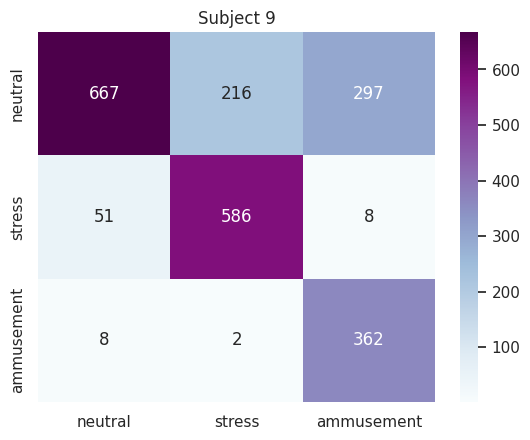

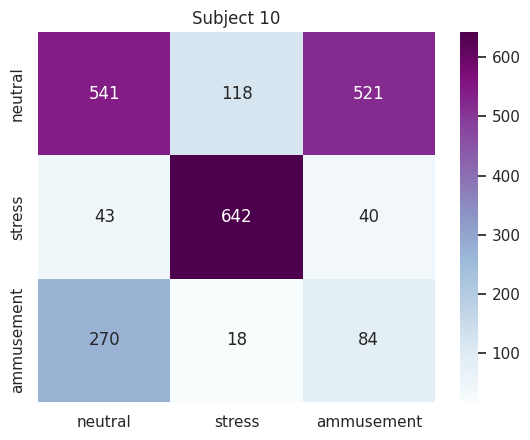

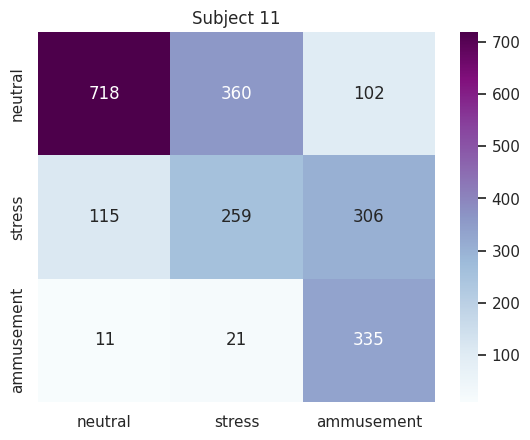

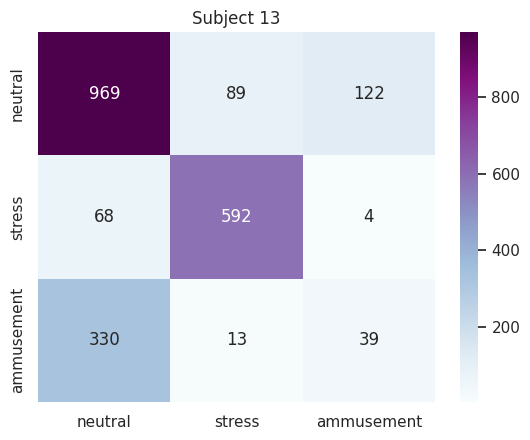

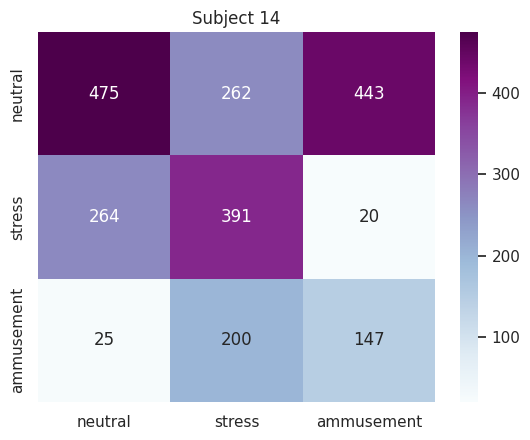

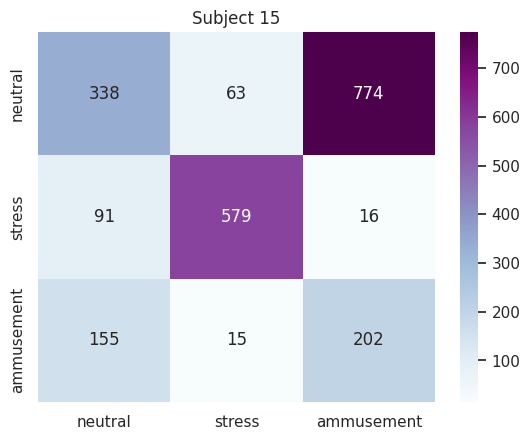

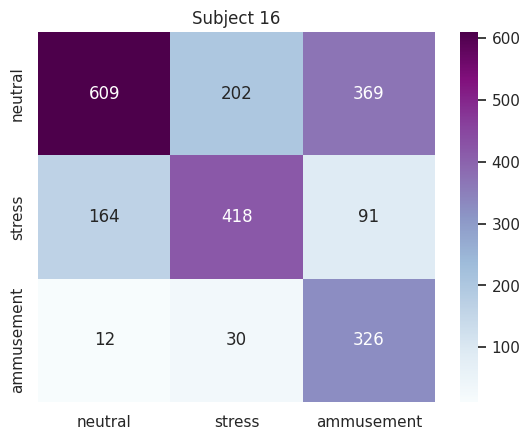

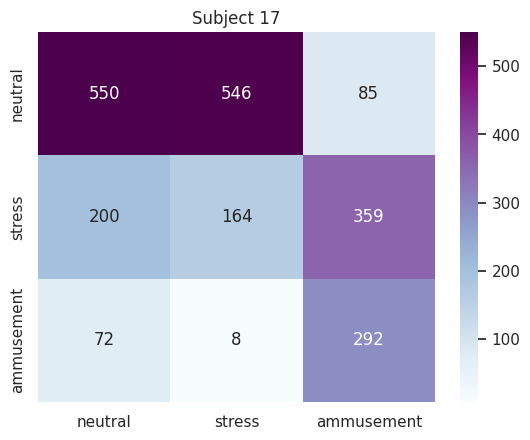

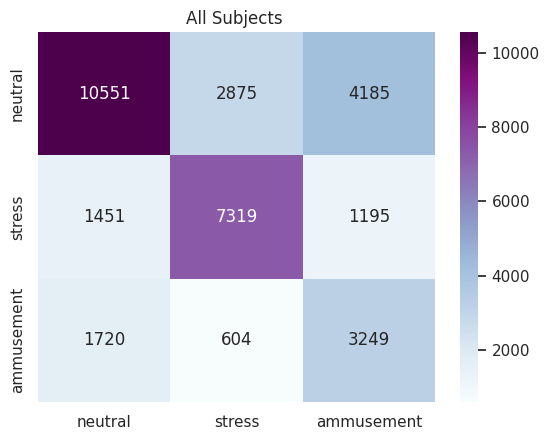

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
cm_all = np.zeros((3,3))
class_names = ['neutral', 'stress', 'ammusement']
for sid, cm in list(zip(np.array(scores_w)[:,0], cms)):
    #print("Subject ", int(sid))
    cm_all += cm
    df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
    sn.set(font_scale=1) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu",  fmt='d') # font size
    plt.title("Subject " + str(int(sid)))
    plt.show()

df_cm = pd.DataFrame(cm_all.astype(int), columns=class_names, index=class_names)
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu",  fmt='d') # font size
plt.title("All Subjects ")
plt.show()

## Accuracies plot

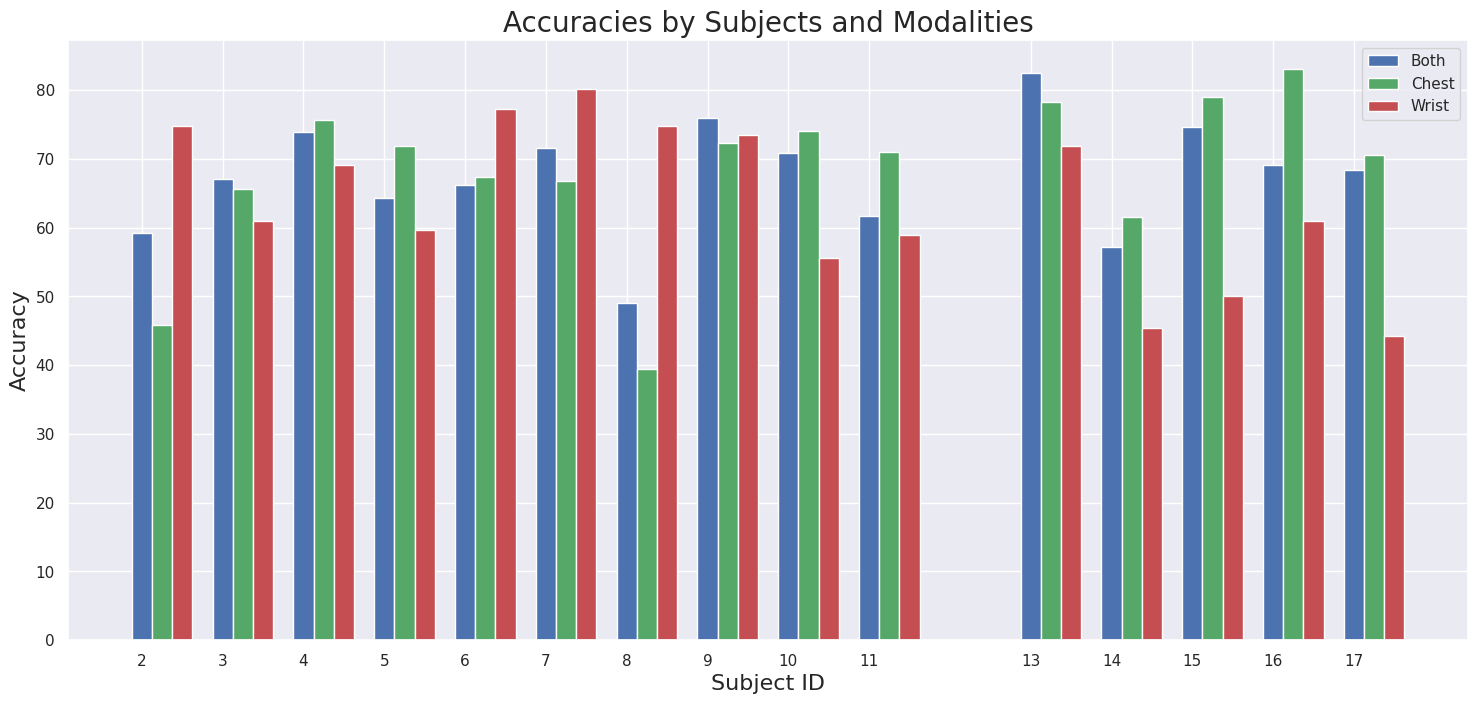

In [ ]:
import matplotlib.pyplot as plt

X = np.arange(15)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_axes([0,0,1,1])
width = 0.25
ind = np.array(scores_all)[:,0].astype(int)
ax.set_xticks(ind)
ax.set_yticks(np.arange(0, 101, 10))
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_xlabel('Subject ID', fontsize=16)
ax.set_title("Accuracies by Subjects and Modalities", fontsize=20)
ax.bar(ind+0.00, np.array(scores_all)[:,1]*100, color = 'b', width = 0.25)
ax.bar(ind+0.25, np.array(scores_c)[:,1]*100, color = 'g', width = 0.25)
ax.bar(ind+0.50, np.array(scores_w)[:,1]*100, color = 'r', width = 0.25)
ax.legend(labels=['Both', 'Chest', 'Wrist'])


## F1-score plot

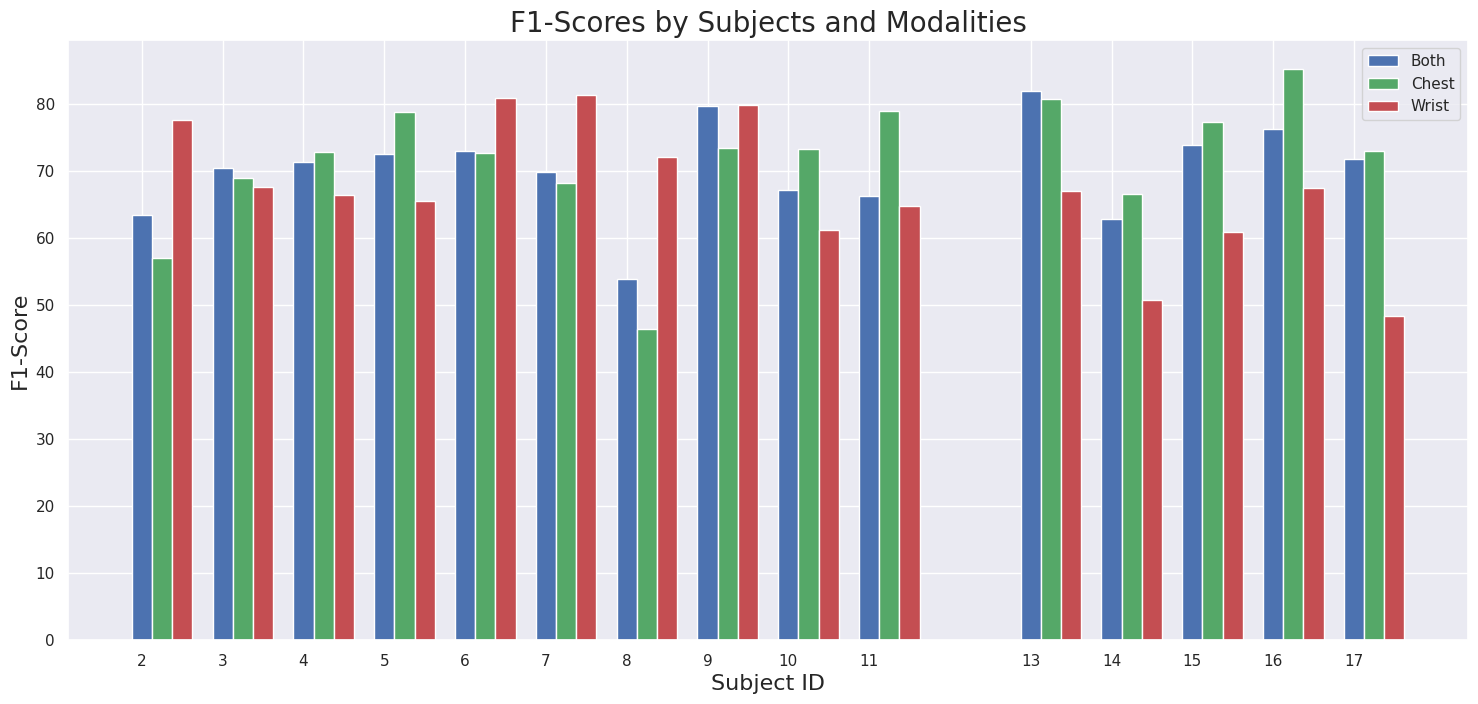

In [ ]:
import matplotlib.pyplot as plt

X = np.arange(15)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_axes([0,0,1,1])
width = 0.25
ind = np.array(scores_all)[:,0].astype(int)
ax.set_xticks(ind)
ax.set_yticks(np.arange(0, 101, 10))
ax.set_ylabel('F1-Score', fontsize=16)
ax.set_xlabel('Subject ID', fontsize=16)
ax.set_title("F1-Scores by Subjects and Modalities", fontsize=20)
ax.bar(ind+0.00, np.array(scores_all)[:,2]*100, color = 'b', width = 0.25)
ax.bar(ind+0.25, np.array(scores_c)[:,2]*100, color = 'g', width = 0.25)
ax.bar(ind+0.50, np.array(scores_w)[:,2]*100, color = 'r', width = 0.25)
ax.legend(labels=['Both', 'Chest', 'Wrist'])